<a target="_blank" href="https://colab.research.google.com/github/pr4deepr/cellpose-colab/blob/main/Cellpose_cell_segmentation_2D_prediction_only.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

#**Cellpose Prediction for 2D v0.5**
A generalist algorithm for cell and nucleus segmentation.

***Cellpose code: Carsen Stringer & Marius Pachitariu***

[Link to Paper](https://www.nature.com/articles/s41592-020-01018-x)

[Link to Video talk](https://t.co/JChCsTD0SK?amp=1)

Github Repo: https://github.com/MouseLand/cellpose

The notebook is for processing **2D** images using the Cellpose package on Google Colab using the GPU. It processes images within the folder specified by the user. It will generate a folder called Masks which will contain the label images generated by Cellpose.

The user can fine-tune and preview the parameters on one image before running it on all images within the folder. The user-specified channel will be used on all images for segmentation.

This notebook was inspired by the [ZeroCostDL4Mic notebook series](https://github.com/HenriquesLab/ZeroCostDL4Mic/wiki). It was also adapted from colab notebook by Matteo Carandini hosted on the Cellpose github page.

I have only tested it on jpg and tiff files. Feel free to email me if you have any questions.

**This notebook uses cellpose v2.3.2.**

v0.5 update:

* 2024/04/09 Constrained cellpose version to be 2.3.2 to maintain compatibility.


v0.4 update:

* Fixed bug where new models could not be used for prediction


v0.3 update:

* Updated for Cellpose 2.0
* New models incorporated: https://cellpose.readthedocs.io/en/latest/models.html
* Parameters used in cellpose will be saved as a txt file (Thanks for suggestion Kota Miura)



***Author of this notebook: Pradeep Rajasekhar***

***Walter and Eliza Hall Institute of Medical Research, Melbourne, Australia***

rajasekhar.p@wehi.edu.au

#**Configuration**

### Make sure you have GPU access enabled by going to Runtime -> Change Runtime Type -> Hardware accelerator and selecting GPU

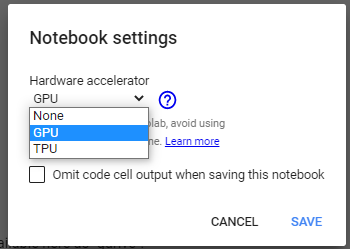

In [7]:
#@markdown ##Step 1: Run this cell to connect your Google Drive to colab

#@markdown * Click on the URL.

#@markdown * Sign in your Google Account.

#@markdown You will either have to:
#@markdown * copy the authorisation code and enter it into box below OR

#@markdown * in the new google colab, you can just click "Allow" and it should connect.

#@markdown * Click on "Folder" icon on the Left, press the refresh button. Your Google Drive folder should now be available here as "gdrive".

# mount user's Google Drive to Google Colab.
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


###**How to get google drive path to your images**

The above step allows this colab notebook to access your images from google drive. Now, you need the path of your folder containing the images. On the left of your notebook you will see a file icon:

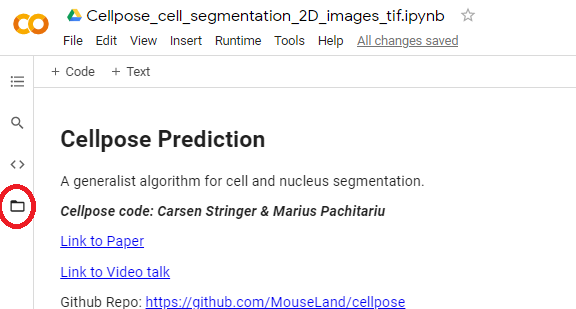

Click on the icon and it will give you:

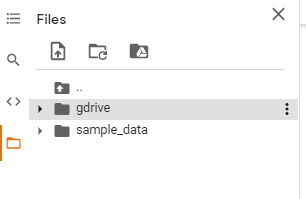

Your Google drive is under "gdrive". Click on the triangle icon on left of gdrive and it will be a dropdown view of your whole drive. Navigate to the folder containing your images. Once you are there, click on the three dots on the right of the folder and select "Copy Path"

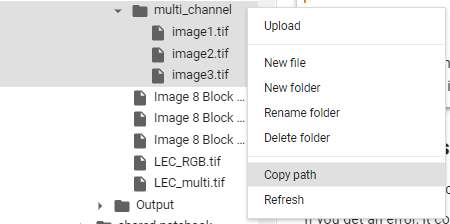

Copy and paste this path under the **Input_Directory** location below



---


# **Setup Cellpose**



Install GPU version of Cellpose and configure dependencies


In [8]:
#@markdown ##Step 2: Click Play to Install Cellpose
#@markdown **PLEASE WAIT FOR THIS CELL TO COMPLETE AND YOUR RUN TIME TO RESTART BEFORE CONTINUING TO STEP 3**
#@markdown * After cellpose installation, the runtime will restart a warning that it has **crashed**, which is fine. This is essential to configure the environment.


#@markdown * On occasion, you may not be able to see the folders on the left panel. Just refresh your browser webpage and it should appear.
#!pip install git+https://www.github.com/mouseland/cellpose.git #to install development version
!pip install "cellpose==2.3.2"
!pip install torch torchvision torchaudio
!pip install omnipose

#Fix opencv error: ImportError: cannot import name '_registerMatType' from 'cv2.cv2'
!pip install "opencv-python-headless<4.3"
exit(0) #Restart Runtime to use newly installed numpy
#or may get the error: ValueError: numpy.ndarray size changed, may indicate binary incompatibility. Expected 88 from C header, got 80 from PyObject

#https://stackoverflow.com/questions/8924173/how-do-i-print-bold-text-in-python
BOLD = '\033[1m'
UNDERLINE = '\033[4m'
END = '\033[0m'



print("\n"+BOLD+UNDERLINE+"Restarting the RUNTIME. Wait till you see the green tick on the right top, next to RAM and Disk before proceeding."+END)



Restarting the RUNTIME. Wait till you see the green tick on the right top, next to RAM and Disk before proceeding.


In [1]:
#@markdown ##Step 3: Once **Step 2 is completed**, run this cell to configure Cellpose, dependencies and check GPU access
#@markdown

#@markdown *Models will be downloaded when running for the first time*
#disabled installation and import of mxnet as pytorch is the default neural net
import numpy as np
import time, os, sys, random
from urllib.parse import urlparse
import skimage.io
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
mpl.rcParams['figure.dpi'] = 300

from urllib.parse import urlparse
import shutil

#from tifffile import imread, imsave


print ("Downloading Models")
from cellpose import models,core

model_list = models.MODEL_NAMES

#Enable Logging
from cellpose.io import logger_setup
logger_setup()

#https://stackoverflow.com/questions/8924173/how-do-i-print-bold-text-in-python
BOLD = '\033[1m'
UNDERLINE = '\033[4m'
END = '\033[0m'

#Check if colab notebook instance has GPU access
if core.use_gpu()==False:
  #Warnings from the ZeroCost StarDist notebook
  print(BOLD+UNDERLINE+'You do not have GPU access.'+END)
  print('Did you change your runtime ?')
  print('If the runtime setting is correct then Google did not allocate a GPU for your session')
  print('Expect slow performance. To access GPU try reconnecting later')
  use_GPU=False
else:
  print(BOLD+UNDERLINE+"You have access to the GPU."+END+"\nDetails are:")
  print("*************************************************")
  !nvidia-smi
  use_GPU=True

print("*************************************************")
print("Libraries imported and configured")


You have access to the GPU.
Details are:
*************************************************
Wed Nov  6 08:37:25 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   71C    P0              14W /  70W |    105MiB / 15360MiB |      0%      Default |
|                                         |                      | 

In [2]:
#@markdown ###Step 4: Enter Directory path containing the images:
#@markdown ##### Existing Masks directory will be deleted. (Does not read images in subfolders)
Input_Directory = "/content/gdrive/MyDrive/downsampled_data" #@param {type:"string"}
input_dir = os.path.join(Input_Directory, "") #adds separator to the end regardless if path has it or not

#@markdown ###Optional: Enter image extension here to read only files/images of specified extension (.tif,.jpg..):
#@markdown ###### Leave empty if not specifying anything
image_format = ".tiff" #@param {type:"string"}

##@markdown ###Tick if image is RGB:
#RGB= False #@param {type:"boolean"}
#rgb=RGB
save_dir = input_dir+"Masks/"
if not os.path.exists(save_dir):
  os.makedirs(save_dir)
else:
  print("Existing Mask Directory found. Deleting it.")
  shutil.rmtree(save_dir)

#@markdown ##### Save Directory will be created in the input path under Masks

##@markdown ###Advanced Parameters
#Use_Default_Advanced_Parameters = True #@param {type:"boolean"}


# r=root, d=directories, f = files
files=[]

for r, d, f in os.walk(input_dir):
    for fil in f:
      if (image_format):
        if fil.endswith(image_format):
          files.append(os.path.join(r, fil))
      else:
        files.append(os.path.join(r, fil))
    break #only read the root directory; can change this to include levels
if(len(files)==0):
  print("Number of images loaded: %d." %(len(files)))
  print("Cannot read image files. Check if folder has images")
else:
  print("Number of images loaded: %d." %(len(files)))




Number of images loaded: 2877.


No of images loaded are:  2877
Example Image:
r06c03f05_median_aggregated.tiff has 2 dimensions/s
One Channel


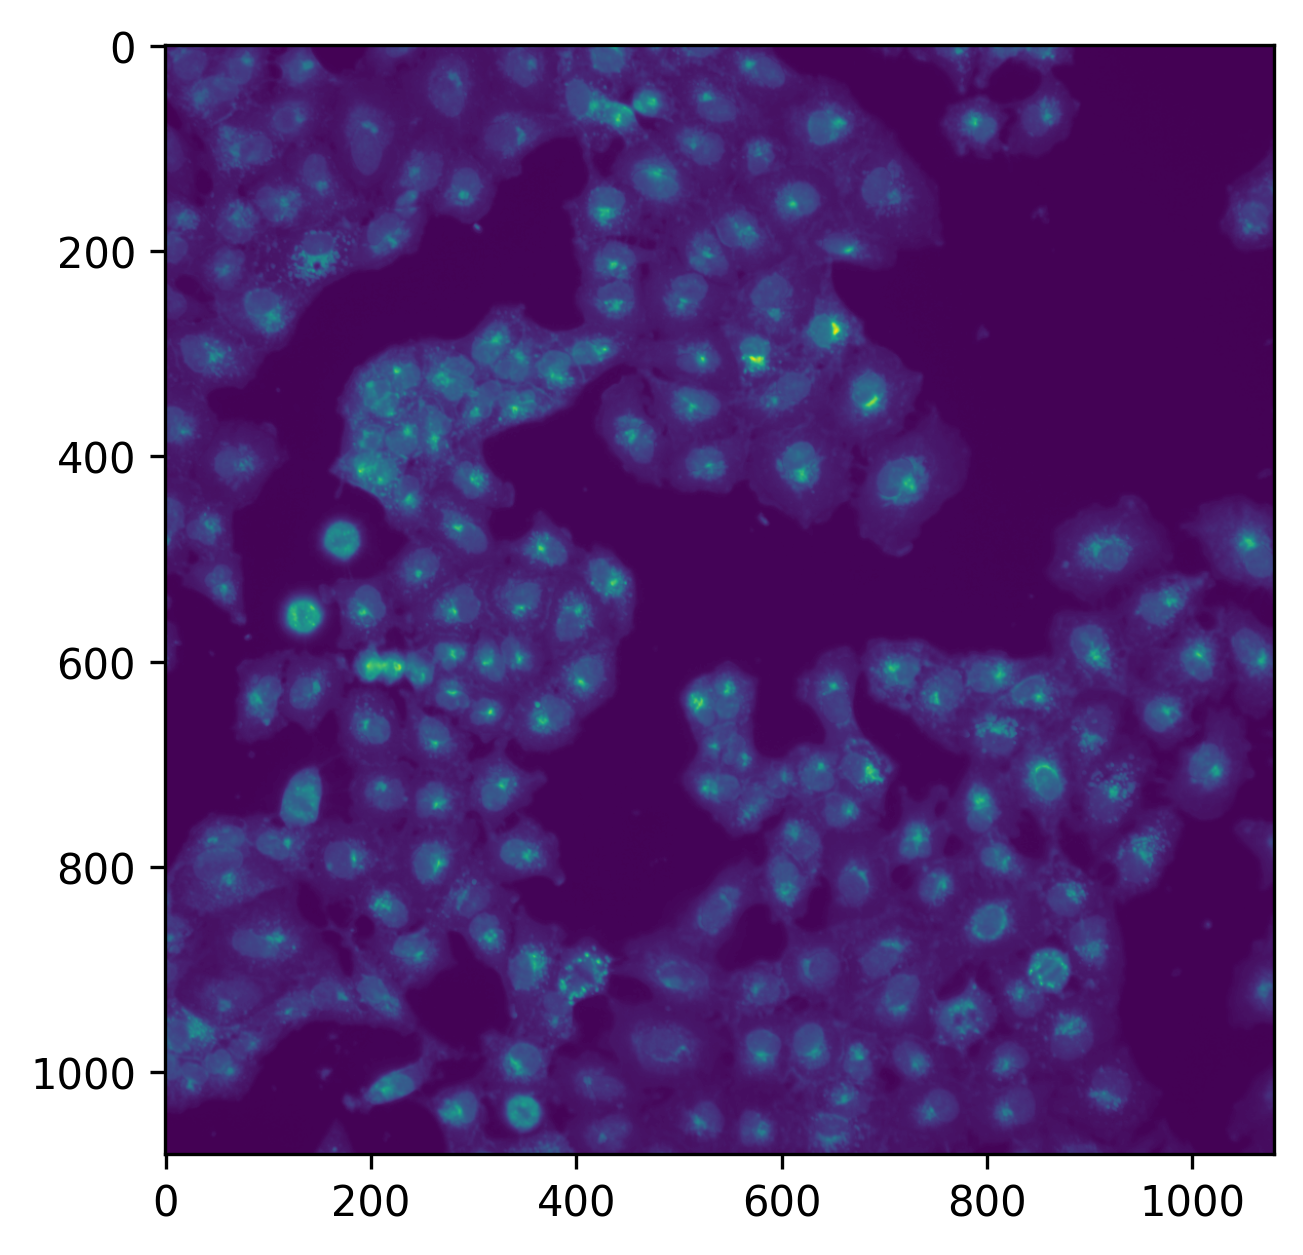

In [3]:
#@markdown ###Step 5: Read and Load all the images
#@markdown #####A random image will be shown as an example with each channel separated. If it is a single channel image, only the one channel will be shown
#imgs = [imread(f) for f in files]

imgs=[] #store all images
#Read images
for f in files:
  im=skimage.io.imread(f)
  n_dim=len(im.shape) #shape of image
  dim=im.shape #dimensions of image
  channel=min(dim) #channel will be dimension with min value usually
  channel_position=dim.index(channel)
  #if no of dim is 3 and channel is first index, swap channel to last index
  if n_dim==3 and channel_position==0:
    #print(dim)
    im=im.transpose(1,2,0)
    dim=im.shape
    #print("Shape changed")
  #print(dim)
  imgs.append(im)

nimg = len(imgs)
print("No of images loaded are: ", nimg)

print("Example Image:")

random_idx = random.choice(range(len(imgs)))
x=imgs[random_idx]
n_dim=len(x.shape)
file_name=os.path.basename(files[random_idx])
print(file_name+" has "+str(n_dim)+" dimensions/s")
if n_dim==3:
  channel_image=x.shape[2]
  fig, axs = plt.subplots(1, channel_image,figsize=(12,5))
  print("Image: %s" %(file_name))
  print("Image number: ",random_idx+1)
  for channel in range(channel_image):
      axs[channel].imshow(x[:,:,channel])
      axs[channel].set_title('Channel '+str(channel+1),size=15)
      axs[channel].axis('off')
  fig.tight_layout()
elif n_dim==2:
  print("One Channel")
  plt.imshow(x)
else:
  print("Channel number invalid or dimensions wrong. Image shape is: "+str(x.shape))



---


# **Define and Test Cellpose parameters for segmentaiton**



#### In section, we define:

*   Channels for segmentation
*   Cellpose Parameters:
    * Diameter
    * Flow Threshold
    * Cell Probability Threshold

More info on Models: https://cellpose.readthedocs.io/en/latest/models.html

#### As a general rule of thumb, segmentation of a cell using a membrane/cytoplasm dye is more accurate when used in combination with a nuclei marker.


In [5]:
#@markdown #### **STEP 6**.  RUN THIS CELL to CHOOSE a cellpose model. Select the model you want from the dropdown list.
import ipywidgets as widgets
from IPython.display import display

model_choices = widgets.Dropdown(
    options=model_list,
    value='cyto2',
    description='Model Choice:',
    disabled=False,
)

def on_change(model_change):
  print("Model changed to :",model_change.new)
print("Choose MODEL from this list before proceeeding. Default is cyto2:")
model_choices.observe(on_change,names = 'value')

display(model_choices)



Choose MODEL from this list before proceeeding. Default is cyto2:


Dropdown(description='Model Choice:', index=4, options=('cyto', 'nuclei', 'tissuenet', 'livecell', 'cyto2', 'g…

Model changed to : LC1


In [6]:
#@markdown #### **STEP 7**.  Define the channels to use for segmentation

model_type= model_choices.value
print("Using model ",model_type)

#@markdown If the image has only one channel, leave it segmentation channel as 0
Channel_for_segmentation="1" #@param[0,1,2,3,4,5]
segment_channel=int(Channel_for_segmentation)

# @markdown ###If you choose cytoplasm, tick if you have a nuclear channel
Use_nuclear_channel= True #@param {type:"boolean"}
Nuclear_channel="3" #@param[1,2,3,4,5]
nuclear_channel=int(Nuclear_channel)

# @markdown ###If cells are elongated or have branches, tick this. It will use omnipose

#disabling omnipose for now as the flag has been removed from CELLPOSE
#omni= False #@param {type:"boolean"}


#@markdown ### Diameter of cell (pixels):
#@markdown #### Enter 0 if you don't know and cellpose will estimate it automatically. You can define this later as well.
Diameter =  0#@param {type:"number"}
diameter=Diameter

# define CHANNELS to run segementation on
# grayscale=0, R=1, G=2, B=3
# channels = [cytoplasm, nucleus]
# if NUCLEUS channel does not exist, set the second channel to 0
# channels = [0,0]
# IF ALL YOUR IMAGES ARE THE SAME TYPE, you can give a list with 2 elements
# channels = [0,0] # IF YOU HAVE GRAYSCALE
# channels = [2,3] # IF YOU HAVE G=cytoplasm and B=nucleus
# channels = [2,1] # IF YOU HAVE G=cytoplasm and R=nucleus


#if model_choice=="Cytoplasm":
#  model_type="cyto"

##elif model_choice=="Cytoplasm2":
##  model_type="cyto2"

#elif model_choice=="Cytoplasm2_Omnipose":
#  model_type="cyto2_omni"

#elif model_choice=="Bacteria_Omnipose":
#  model_type="bact_omni"
#  diameter = 0

#elif model_choice=="Nuclei":
#  model_type="nuclei"


# channels = [cytoplasm, nucleus]
if model_type != "nuclei":
  if Use_nuclear_channel:
    channels=[segment_channel,nuclear_channel]
  else:
    channels=[segment_channel,0]
else: #nucleus
  channels=[segment_channel,0]




# DEFINE CELLPOSE MODEL
# model_type='cyto' or model_type='nuclei'
model = models.CellposeModel(gpu=use_GPU, model_type=model_type, net_avg = True)#, omni = omni

# define CHANNELS to run segementation on
# grayscale=0, R=1, G=2, B=3
# channels = [cytoplasm, nucleus]
# if NUCLEUS channel does not exist, set the second channel to 0
# channels = [0,0]
# IF ALL YOUR IMAGES ARE THE SAME TYPE, you can give a list with 2 elements
# channels = [0,0] # IF YOU HAVE GRAYSCALE
# channels = [2,3] # IF YOU HAVE G=cytoplasm and B=nucleus
# channels = [2,1] # IF YOU HAVE G=cytoplasm and R=nucleus

# or if you have different types of channels in each image
#channels = [[2,3], [0,0], [0,0]]

# if diameter is set to None, the size of the cells is estimated on a per image basis
# you can set the average cell `diameter` in pixels yourself (recommended)
# diameter can be a list or a single number for all images
if diameter == 0:
  diameter = None
  print("Diameter is set to None. The size of the cells will be estimated on a per image basis")

Using model  LC1


100%|██████████| 25.3M/25.3M [00:00<00:00, 31.3MB/s]
/usr/local/lib/python3.10/dist-packages/cellpose/resnet_torch.py:225: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  stat

Diameter is set to None. The size of the cells will be estimated on a per image basis


####**Step 7.1: Test cellpose on an image. You can tune the parameters below based on your image**

The cell below gives you an opportunity to test different parameters and figure out the right combination that gives your output of interest

The ***Flow_threshold parameter*** is  the  maximum  allowed  error  of  the  flows  for  each  mask.   The  default  is 0.4.

*   **Increase** this threshold if cellpose is not returning as many masks as you’d expect

*   **Decrease** this threshold if cellpose is returning too many ill-shaped masks.

The ***Cell Probability Threshold*** determines proability that a detected object is a cell.   The  default  is 0.0.

*   **Decrease** this threshold if cellpose is not returning as many masks as you’d expect or if masks are too small

*   **Increase** this threshold if cellpose is returning too many masks esp from dull/dim areas.

If you do not know **diameter** of the cells OR if cells are of varying diameters, enter 0 in the Diameter box and cellpose will automatically estimate the diameter

For more information on the parameters: https://cellpose.readthedocs.io/_/downloads/en/latest/pdf/

Image: r05c22f06_median_aggregated


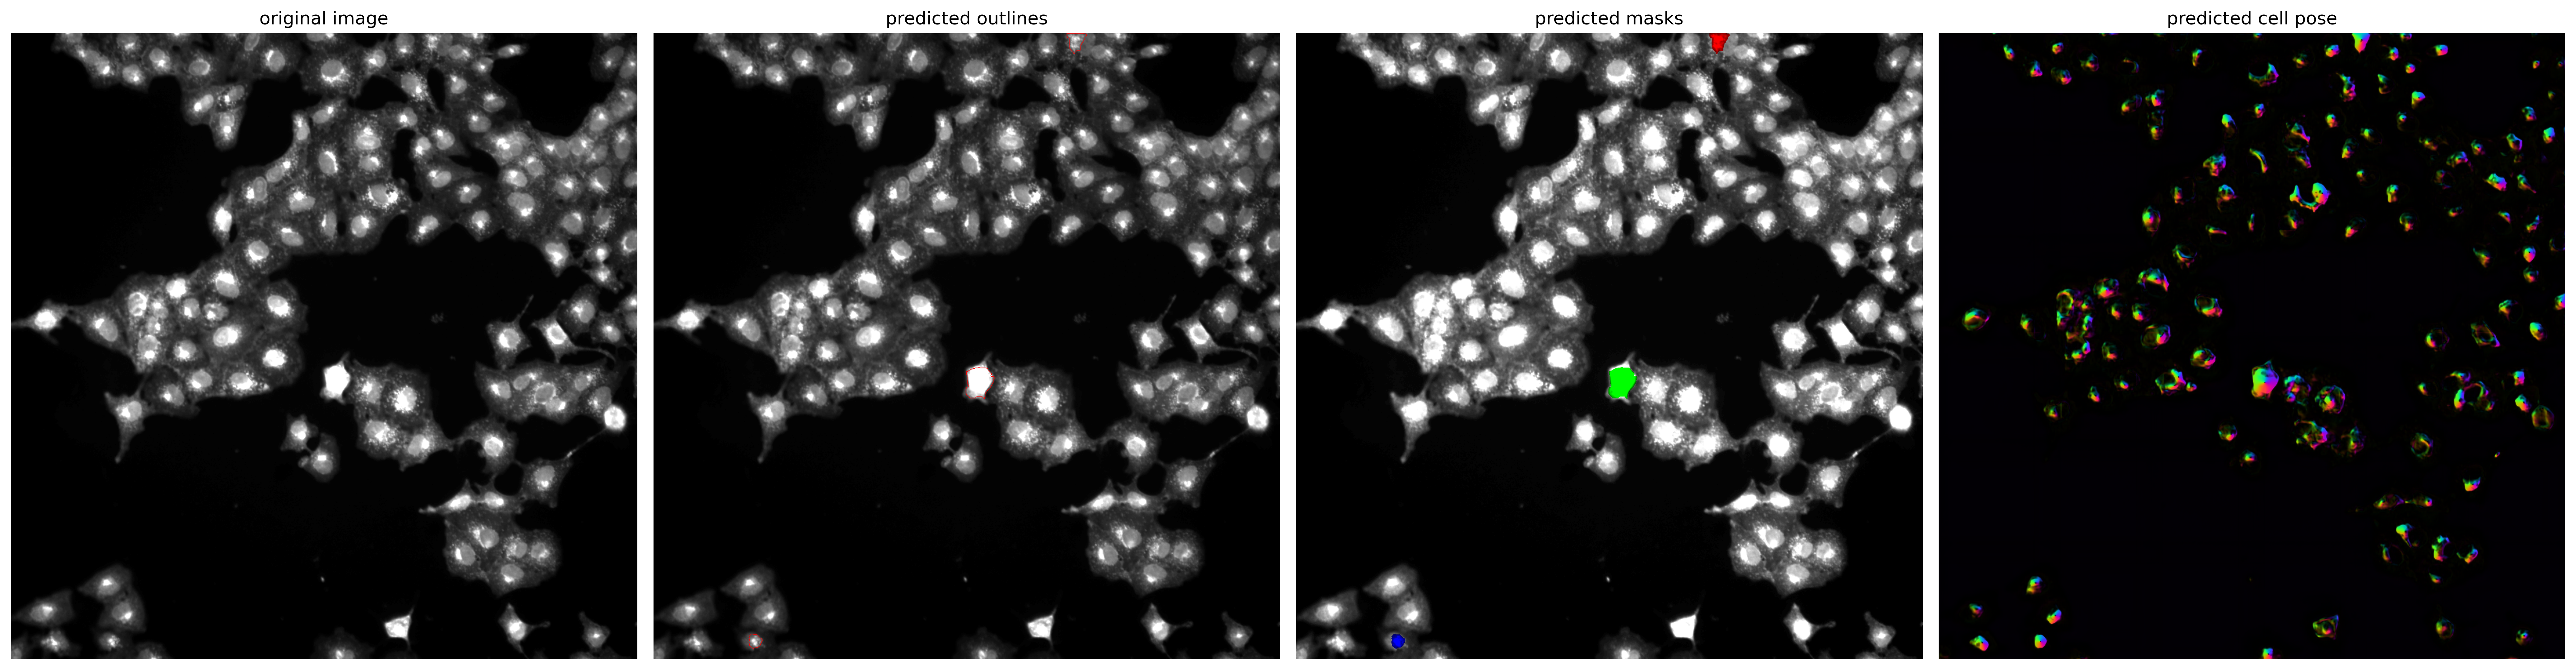

In [7]:
from skimage.util import img_as_ubyte

Image_Number =  2#@param {type:"number"}
Image_Number-=1 #indexing starts at zero
#print(Image_Number)
Diameter = 0#@param {type:"number"}
#Flow_Threshold=0.4#@param {type:"number"}
Flow_Threshold = 0.6 #@param {type:"slider", min:0.1, max:1.1, step:0.1}
flow_threshold=Flow_Threshold

#Cell_Probability_Threshold=-5#@param {type:"number"}
#Using slider to restrict values
Cell_Probability_Threshold=-5 #@param {type:"slider", min:-6, max:6, step:1}
cellprob_threshold=Cell_Probability_Threshold


diameter=Diameter
if diameter == 0:
  diameter = None
if Image_Number == -1:
  Image_Number=0
  #print("Image_Number is set to zero, opening first image.")
try:
    image = imgs[Image_Number]
except IndexError as i:
   print("Image number does not exist",i)
   print("Actual no of images in folder: ",len(imgs))
print("Image: %s" %(os.path.splitext(os.path.basename(files[Image_Number]))[0]))
img1=imgs[Image_Number]

import cv2

masks, flows, styles = model.eval(img1, diameter=diameter, flow_threshold=flow_threshold,cellprob_threshold=cellprob_threshold, channels=channels)
#masks, flows, styles, diams = model.eval(img1, diameter=diameter, flow_threshold=flow_threshold,cellprob_threshold=cellprob_threshold, channels=channels)



# DISPLAY RESULTS
from cellpose import plot
maski = masks
flowi = flows[0]

#convert to 8-bit if not so it can display properly in the graph
if img1.dtype!='uint8':
  img1=img_as_ubyte(img1)

fig = plt.figure(figsize=(24,8))
#if len(img1.shape)==3:
  #img_ch_plot = img1[:,:,segment_channel]img_ch_plot
plot.show_segmentation(fig, img1 , maski, flowi, channels=channels)
plt.tight_layout()
plt.show()



---


## **USE CELLPOSE TO SEGMENT CELLS**
The values defined above will be used for segmentation.

The masks will be saved automatically.

Saving the flow image/s are optional. Tick if you want to save them.



In [ ]:
#@markdown ### **Step 8. Run Cellpose on folder of images**

#@markdown ###Tick if you want to save the flow image/s:
Save_Flow= False #@param {type:"boolean"}
#@markdown ##### *Flow image will be resized when saved
save_flow=Save_Flow

print("Running segmentation on channel %s" %(segment_channel))
print("Using the model: ",model_type)
if diameter is None:
  print("Diameter will be estimated from the image/s")
else:
  print(f"Cellpose will use a diameter of {diameter}")

print(f"Using a flow threshold of: {flow_threshold} and a cell probability threshold of: {cellprob_threshold}")

#if too many images, it will lead to memory error.
#will evaluate on a per image basis
#masks, flows, styles, diams = model.eval(imgs, diameter=diameter, flow_threshold=flow_threshold,cellprob_threshold=cellprob_threshold, channels=channels)


#save images in folder with the diameter value used in cellpose
print("Segmentation Done. Saving Masks and flows now")
print("Save Directory is: ",save_dir)
if (not os.path.exists(save_dir)):
    os.mkdir(save_dir)

if save_flow:
  print("Saving Flow")
  flows_save_dir=save_dir+"flows"+os.sep
  print("Save Directory for flows is: ",flows_save_dir)
  if (not os.path.exists(flows_save_dir)):
      os.mkdir(flows_save_dir)


for img_idx, img in enumerate(imgs):
    file_name=os.path.splitext(os.path.basename(files[img_idx]))[0]
    print("\nSegmenting: ",file_name)
    #mask, flow, style, diam = model.eval(img, diameter=diameter, flow_threshold=flow_threshold,cellprob_threshold=cellprob_threshold, channels=channels)
    mask, flow, style = model.eval(img, diameter=diameter, flow_threshold=flow_threshold,cellprob_threshold=cellprob_threshold, channels=channels)
    #save images in folder with the diameter value used in cellpose
    print("Segmentation complete . Saving Masks and flows")
    #Output name for masks
    mask_output_name=save_dir+"MASK_"+file_name+".tif"
    #Save mask as 16-bit in case this has to be used for detecting than 255 objects
    mask=mask.astype(np.uint16)
    #Save flow as 8-bit
    skimage.io.imsave(mask_output_name,mask, check_contrast=False)
    if save_flow:
      #Output name for flows
      flow_output_name=flows_save_dir+"FLOWS_"+file_name+".tif"
      #Save as 8-bit
      flow_image=flow[0].astype(np.uint8)
      skimage.io.imsave(flow_output_name,flow_image, check_contrast=False)

#Save parameters used in Cellpose
parameters_file=save_dir+"Cellpose_parameters_used.txt"
outFile=open(parameters_file, "w")
outFile.write("CELLPOSE PARAMETERS\n")
outFile.write("Model: "+model_type+"\n")
if diameter == 0:
  diameter = "Automatically estimated by cellpose"
#outFile.write("Omni Flag: "+str(omni)+"\n")
outFile.write("Diameter: "+str(diameter)+"\n")
outFile.write("Flow Threshold: "+str(flow_threshold)+"\n")
outFile.write("Cell probability Threshold: "+str(cellprob_threshold)+"\n")
outFile.close()
print("\nSegmentation complete and files saved")

---
#**How to extract the ROIs from the mask or label maps using FIJI**

The masks will be saved as a 16-bit label image, where each cell/ROI is a different colour or label. If you are using ImageJ/FIJI and want to convert this to ROIs for the ROI Manager, there are a few options to convert into ROIs:


*   SCF plugin (Update site:	https://sites.imagej.net/SCF-MPI-CBG/). After [installing the plugin](https://imagej.net/How_to_follow_a_3rd_party_update_site), go to SCF-> Segmentation -> LabelMap to ROI Manager (2D). This should generate the ROIs in ROI Manager

*   Another really nice plugin: [LabelsToROIs](https://github.com/ariel-waisman/LabelsToROis). It has some nice features to adjust the size of the ROIs and generate measurements  


###**Save Files as *.npy**

If you want to save the files so as to view it in the Cellpose GUI, you can save it as an *_seg.npy files in colab that you can download and open in the GUI.

The file/s will be saved in the Input_Directory


In [ ]:
#@markdown ### **Run this cell to save output of the model as an npy file**
from cellpose import io

#save output of model eval to be loaded in GUI
io.masks_flows_to_seg(imgs, masks, flows, diams, files, channels)



---
**Acknowledgments:**

Thanks to Lior Pytowski from University of Oxford for testing this notebook out and giving some really good suggestions
